In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5

In [ ]:
# ENV["JULIA_DEBUG"] = "BAT"

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements

In [3]:
# using Revise
using BAT 

# Low `p` Population: 

In [40]:
conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-1.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
)

images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
event_number = 9

# Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

# High `p` Population: 

In [41]:
# conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-1.jld2")

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# ) 

# images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
# event_number = 9

# # Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );


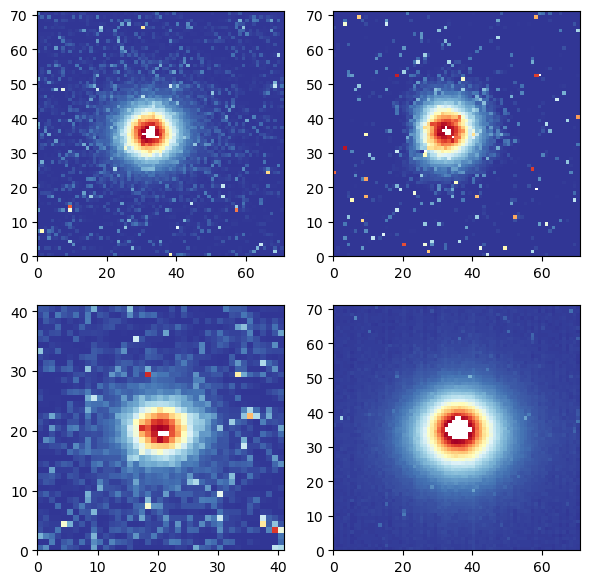

PyObject <matplotlib.collections.QuadMesh object at 0x7fb8db184df0>

In [17]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [18]:
include("../src/likelihood.jl")
include("../src/utill.jl")

corner_plots (generic function with 1 method)

In [19]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
log_likelihood = let e = event, c = conv_matrices
    
    params -> begin
        
        ll = zero(Float64)
        ll += likelihood_cam13(params, e.cam_1, e.population, c.cam_1, 1)
        ll += likelihood_cam13(params, e.cam_2, e.population, c.cam_2, 2)
        ll += likelihood_cam13(params, e.cam_3, e.population, c.cam_3, 3)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4)
        return LogDVal(ll)
        
    end
end

log_likelihood

In [20]:
param_truth = (
        tr_size = [0.2, 0.2],
        ang_spr = [4.0, 4.0],
        waist = [2.9,],
        algmx = [35,35,20,35], 
        algmy = [35,35,20,35], 
        cam4_ped = 34.3,
        cam4_light_fluct = 2.15,
        cam4_light_amp = event.population*32.16870*10^-2,
        resx = [0, 0, 0], 
        resy = [0, 0, 0], 
        cam4_resx = 0,
        cam4_resy = 0,
        psx = [27.1,21.6,114.], 
        psy = [30.5,23.4,125.],
        cam4_psx = 90.9, #3*0.0303*10^3,
        cam4_psy = 89.4, #3*0.0298*10^3,
        light_amp  = [event.population*35.14744*10^-2, event.population*50.23506*10^-2, event.population*10.09664*10^-2],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

In [21]:
β = 0.015


# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)], # change prior range
#         waist = [Normal(2.9, 0.03)],
#         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         cam4_ped = 4.0 .. 40.0,
#         cam4_light_fluct = 1.0 .. 3.0,
#         cam4_light_amp = 6.6 .. 9.9, # depends on the data truncation
#         resx = [1, 1, 1], 
#         resy = [1, 1, 1], 
#         cam4_resx = 1,
#         cam4_resy = 1,
#         psx = [27.1, 21.6, 114.0], # pixels are in microns
#         psy = [30.5, 23.4, 125.0],
#         cam4_psx = 91.0,
#         cam4_psy = 89.4,
#         light_amp  = [5.0 .. 13.0 , 8.0 .. 17.0, 1.25 .. 4.2],
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     ); # Large Charge 

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)], # change prior range
#         waist = [Normal(2.9, 0.03)],
#         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         cam4_ped = 4.0 .. 40.0,
#         cam4_light_fluct = 1.0 .. 3.0,
#         cam4_light_amp = 1.6 .. 9.9, # depends on the data truncation
#         resx = [1, 1, 1], 
#         resy = [1, 1, 1], 
#         cam4_resx = 1,
#         cam4_resy = 1,
#         psx = [27.1, 21.6, 114.0], # pixels are in microns
#         psy = [30.5, 23.4, 125.0],
#         cam4_psx = 91.0,
#         cam4_psy = 89.4,
#         light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0],
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     ); # Small Charge 


# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
#         waist = [Normal(2.9, 0.03)],
#         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         cam4_ped = 4.0 .. 40.0,
#         cam4_light_fluct = 1.0 .. 3.0,
#         cam4_light_amp = 6.6 .. 9.9, 
#         resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         cam4_resx = truncated(Normal(1, 0.5), 0, Inf),
#         cam4_resy = truncated(Normal(1, 0.5), 0, Inf),
#         psx = [truncated(Normal(27.1, 27.1*β), 0., Inf), truncated(Normal(21.6, 21.6*β), 0., Inf), truncated(Normal(114.0, 114.0*β), 0., Inf)], # pixels are in microns
#         psy = [truncated(Normal(30.5, 30.5*β), 0., Inf), truncated(Normal(23.4, 23.4*β), 0., Inf), truncated(Normal(125.0, 125.0*β), 0., Inf)],
#         cam4_psx = truncated(Normal(91.0, 91.0*β), 0., Inf),
#         cam4_psy = truncated(Normal(89.4, 89.4*β), 0., Inf),
#         light_amp  = [5.0 .. 13.0 , 8.0 .. 17.0, 1.25 .. 4.2], # 1.0 .. 5.0
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     ); # Large Charge


prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 2.6, 5.0), truncated(Normal(4.0, 2.0), 2.6, 5.0)], # changed prior range
        waist = [Normal(2.9, 0.03)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(1, 0.5), 0, Inf),
        cam4_resy = truncated(Normal(1, 0.5), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β), 0., Inf), truncated(Normal(21.6, 21.6*β), 0., Inf), truncated(Normal(114.0, 114.0*β), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β), 0., Inf), truncated(Normal(23.4, 23.4*β), 0., Inf), truncated(Normal(125.0, 125.0*β), 0., Inf)],
        cam4_psx = truncated(Normal(91.0, 91.0*β), 0., Inf),
        cam4_psy = truncated(Normal(89.4, 89.4*β), 0., Inf),
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    ); # Small Charge




In [22]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 50..150,
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 120
);

algorithm = MetropolisHastings();

In [23]:
nsamples = 2*10^5
nchains = 4

4

In [ ]:
# debug
# function likelihood_cam4_debug(
#         params::T, 
#         image::Array{Float64,2},
#         population::Float64,
#         cam_ind::Int64;
#         size = size(event.cam_4)
#     ) where {T <: NamedTuple}
   
#     tot_loglik = zeros(Float64, size...)   
#     light_coefficient::Float64 = population*params.cam4_light_amp
    
#     δ_x::Float64 = params.cam4_psx
#     δ_y::Float64 = params.cam4_psy
    
#     μ_x::Float64  = params.algmx[cam_ind] * δ_x
#     μ_y::Float64  = params.algmy[cam_ind] * δ_y
    
#     σ_x::Float64 = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
#     σ_y::Float64 = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
#     σ_x = sqrt(σ_x^2 + (params.cam4_resx*δ_x).^2)
#     σ_y = sqrt(σ_y^2 + (params.cam4_resy*δ_y).^2)
    

#     for pix_ind in CartesianIndices(tot_loglik)
        
#         x_edge::Float64 = pix_ind.I[1] * δ_x
#         y_edge::Float64 = pix_ind.I[2] * δ_y

#         pix_prediction::Float64 = cdf(Normal(μ_x,σ_x), x_edge) - cdf(Normal(μ_x,σ_x), x_edge - δ_x)
#         pix_prediction *= cdf(Normal(μ_y,σ_y), y_edge) - cdf(Normal(μ_y,σ_y), y_edge - δ_y)
#         pix_prediction = pix_prediction*light_coefficient + params.cam4_ped
#         cum_log_lik = logpdf(truncated(Normal(pix_prediction, params.cam4_light_fluct*sqrt(pix_prediction)), 0.0, 4096), image[pix_ind])

#         if cum_log_lik == Inf
#             @show pix_prediction
#         end
            
#         tot_loglik[pix_ind] = cum_log_lik
#     end

#     return tot_loglik
# end


# v = (tr_size = [0.13994054881826667, 0.1676698052676318], 
#     ang_spr = [4.497291114149412, 3.413546519162755], 
#     waist = [2.9096993275714915], 
#     algmx = [30.738984199066046, 42.29740831831694, 12.142410774266768, 33.40175195100061], 
#     algmy = [40.759269146347876, 38.046372070937124, 10.472521581790856, 34.503228555723865], 
#     resx = [0.9572444190938045, 0.5020069869472927, 1.4432344062410856], 
#     resy = [0.4818830534333988, 2.0626935740749923, 0.025113013362660135], 
#     cam4_resx = 1.272676441079554, 
#     cam4_resy = 2.2631971039163363, 
#     psx = [8.165185793542747, 1.5034197795715056, 0.11296107150924936], 
#     psy = [11.304664627705161, 5.7710223785669115, 0.12130502141542479], 
#     cam4_psx = 7.195608630238003, 
#     cam4_psy = 6.070245659545491, 
#     cam4_ped = 31.26797817690467, cam4_light_fluct = 1.1475150677221286, cam4_light_amp = 31322.92999772482, light_amp = [35147.44, 50235.06, 10096.64], s_cam = [0.0, 1.478, 15.026, 23.115])

# # # log_likelihood(v)

# cont = likelihood_cam4_debug(v, event.cam_4, event.population, 4)

# plt.pcolormesh(cont)

In [24]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

3018.463892 seconds (1.12 G allocations: 638.847 GiB, 3.82% gc time)


In [25]:
size(flatview(unshaped.(samples.v)))

(35, 172405)

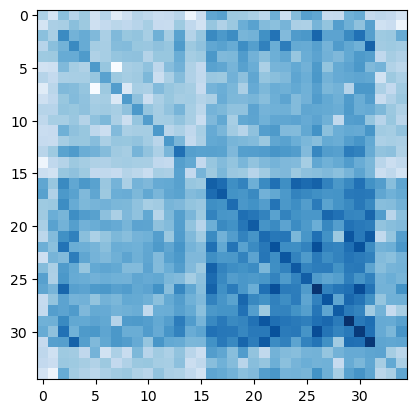

PyObject <matplotlib.image.AxesImage object at 0x7fb8db7c45b0>

In [26]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [38]:
# BAT.bat_write("../data/sampling_results/MultipleEvents/2-Ev_1_2-b.hdf5", unshaped.(samples))

In [27]:
mode(samples)[1]

(tr_size = [0.10932139825466632, 0.10696634221007822], ang_spr = [3.210039381838208, 3.6372156464401937], waist = [2.8949901068346686], algmx = [35.8777559700561, 36.39828484642658, 20.21046105283726, 34.30103710658007], algmy = [32.56371574950144, 33.00967703727211, 20.75002261209479, 36.36607832128108], cam4_ped = 22.44294191124672, cam4_light_fluct = 1.6640163961233991, cam4_light_amp = 2.479253012712873, resx = [2.134749338348707, 0.9338439023901103, 0.1744763816770091], resy = [3.466544623361096, 0.8088321802005871, 1.913419637514195], cam4_resx = 1.6211504159045744, cam4_resy = 0.9855633795351416, psx = [26.930791806057464, 22.152316383056196, 117.0212924638879], psy = [29.789721780310064, 23.72795603173123, 125.38157985779432], cam4_psx = 88.43080824395892, cam4_psy = 90.9125587545555, light_amp = [2.6464996766081605, 3.8970100212870076, 2.069234678102199], s_cam = [0.0, 1.478, 15.026, 23.115])

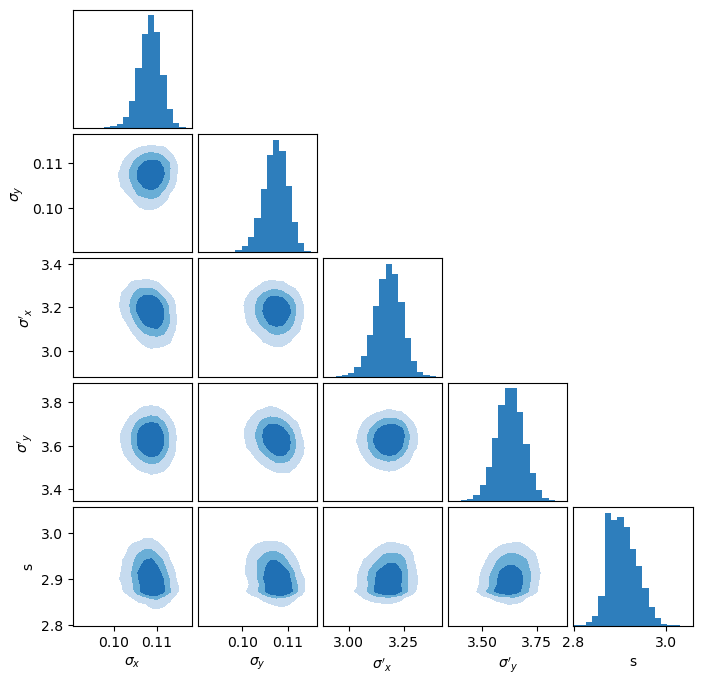

In [28]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

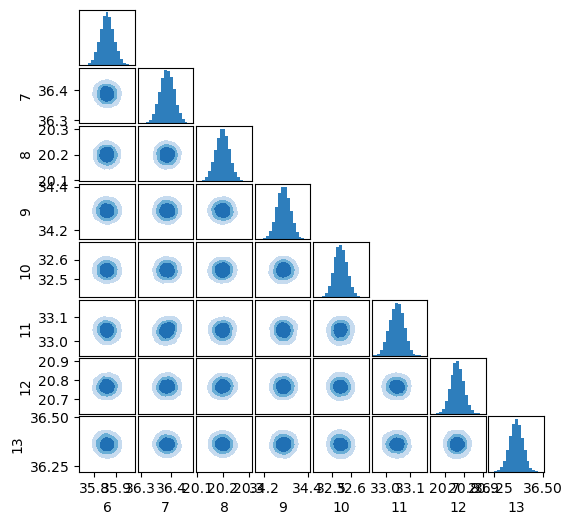

In [29]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

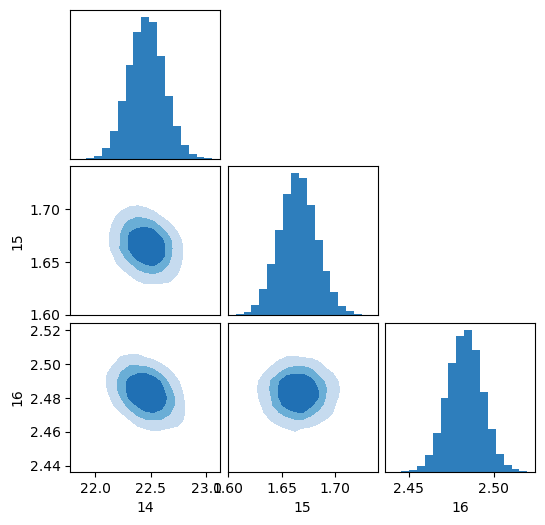

In [30]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

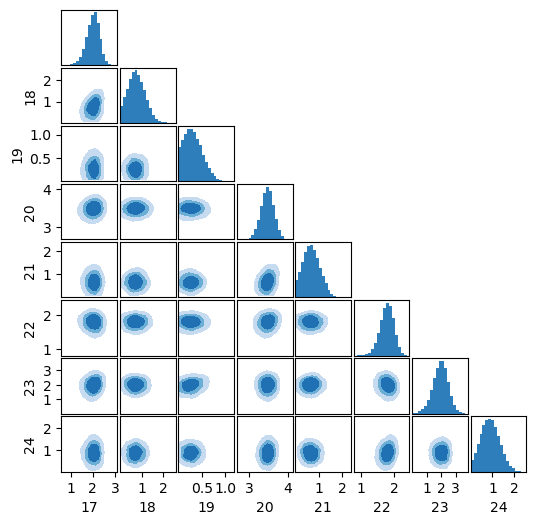

In [31]:
dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

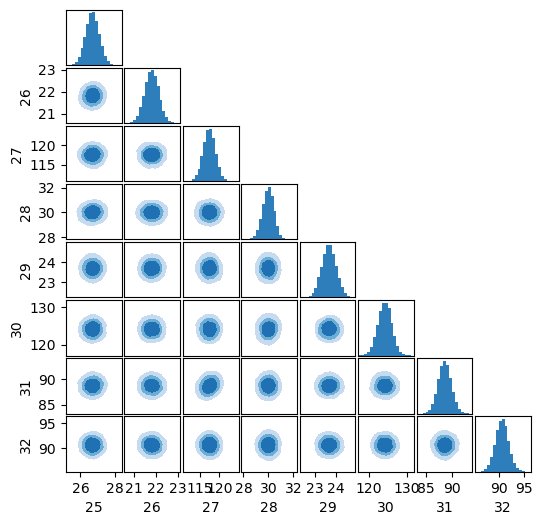

In [32]:
dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

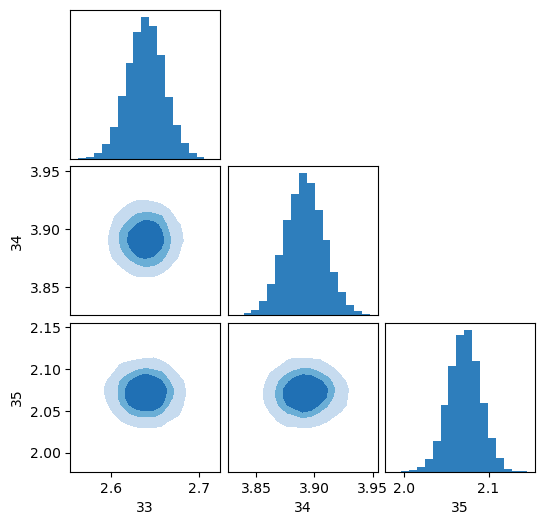

In [33]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

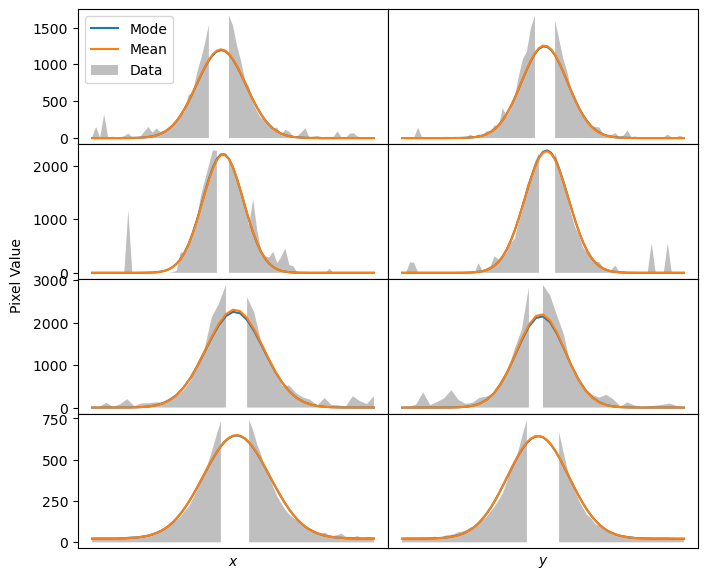

PyObject Text(0.04, 0.5, 'Pixel Value')

In [34]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

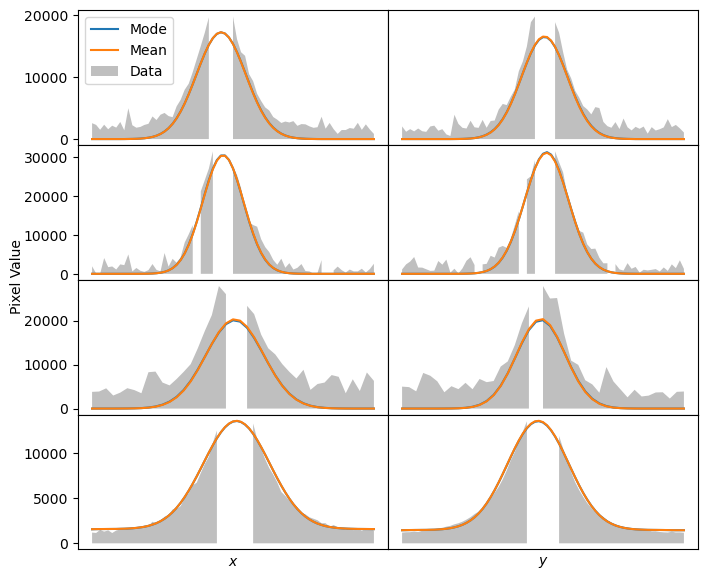

PyObject Text(0.04, 0.5, 'Pixel Value')

In [35]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

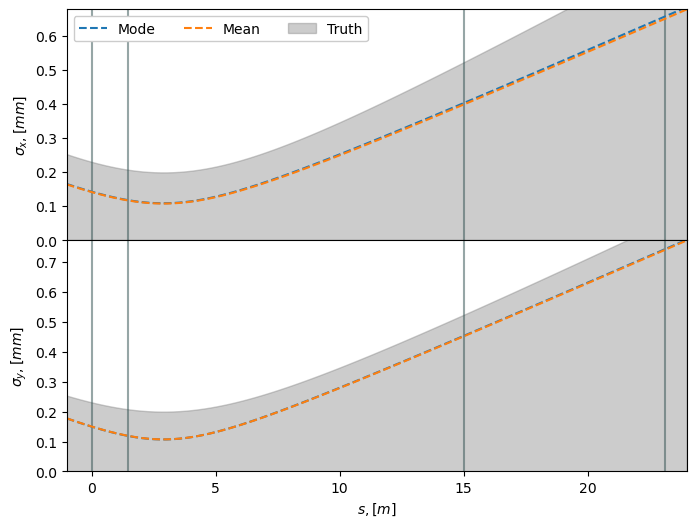

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [36]:
params_array = [param_truth, mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [ ]:
β = 0.015

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
#         δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         is_ped = [29 .. 35],
#         is_light_f = [1.9 .. 2.3,],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


In [ ]:
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        is_ped = [29 .. 35],
        is_light_f = [1.9 .. 2.3,],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 50..150,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 120
);

algorithm = MetropolisHastings();

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
mode(samples)[1]
 
#2.11452269382

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17,18,19,20,21]
names = dims
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22,23,]
names = dims
# levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
# Experiment Event: 

images = load("../data/experiment/dataset_2/m2/images.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)


In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_cam_integral([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [35,35,20,35], 
        μ_y = [35,35,20,35], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# 30 iterationsfro convergence 

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# #40 iterations for convergence 

In [ ]:
β_min = 0.6
β_max = 1.4

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
    
        int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
                β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
                β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
                β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );

# 43 chains for convergence 

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..208,
#     max_nsamples_init = 600,
#     max_nsteps_init = 600,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 1700,
#     max_nsteps_per_cycle = 1700,
#     max_time_per_cycle = Inf,
#     max_ncycles = 60
# );

# nsamples = 6*10^4
# nchains = 4;

In [ ]:
# resolution + prior AWAKE 

β_min = 0.7
β_max = 1.3

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(3.07, 0.5), 0, 5), truncated(Normal(3.95, 0.5), 0, 5), truncated(Normal(2.13, 0.5), 0, 5), truncated(Normal(2.16, 0.5), 0, 5)], 
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [3.07, 3.95, 2.13, 2.16],
        σ_y = [3.07 , 3.95, 2.13, 2.16], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [0, 0, 0, 0],
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


# #40 iterations for convergence 
# res 1: mean([0.0874, 0.0895] ./ [0.0270999, 0.03049999999999997])
#res2: [0.021599999999999397, 0.023400000000000087] ./ [0.0861, 0.0918]
# res 3: mean([0.303, 0.201] ./ [0.11400000000000077, 0.125])
# res4: mean([0.202, 0.189] ./ [0.030303030303030304, 0.02981267596704524] ) / 3

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

In [ ]:
β = 0.015

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        δ_x = [truncated(Normal(0.0271, 0.0271*β), 0, Inf), truncated(Normal(0.0216, 0.0216*β), 0, Inf), truncated(Normal(0.114, 0.114*β), 0, Inf), truncated(Normal(0.091, 0.091*β), 0, Inf)], 
        δ_y = [truncated(Normal(0.0305, 0.0305*β), 0, Inf), truncated(Normal(0.0234, 0.0234*β), 0, Inf), truncated(Normal(0.125, 0.125*β), 0, Inf), truncated(Normal(0.0894, 0.0894*β), 0, Inf)], 
        int_coeff  = [Normal(35147.44, β*35147.44), Normal(50235.06, β*50235.06), Normal(10096.64, β*10096.64), Normal(33406.9, β*33406.9)],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );



In [ ]:
# β_min = 0.9
# β_max = 1.1

# prior = NamedTupleDist(
#         tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
#         ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
#         s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
#         μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
#                 β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
#                 β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
#                 β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
#         μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
#                 β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
#                 β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
#                 β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
#         σ_x = [0,0,0,0], 
#         σ_y = [0,0,0,0], 
#         δ_x = [ β_min*param_truth.δ_x[1]..β_max*param_truth.δ_x[1],
#                 β_min*param_truth.δ_x[2]..β_max*param_truth.δ_x[2],
#                 β_min*param_truth.δ_x[3]..β_max*param_truth.δ_x[3],
#                 β_min*param_truth.δ_x[4]..β_max*param_truth.δ_x[4]],
    
#         δ_y = [ β_min*param_truth.δ_y[1]..β_max*param_truth.δ_y[1],
#                 β_min*param_truth.δ_y[2]..β_max*param_truth.δ_y[2],
#                 β_min*param_truth.δ_y[3]..β_max*param_truth.δ_y[3],
#                 β_min*param_truth.δ_y[4]..β_max*param_truth.δ_y[4]],
    
#         int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
#                 β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
#                 β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
#                 β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..200,
#     max_nsamples_init = 2000,
#     max_nsteps_init = 2000,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 5000,
#     max_nsteps_per_cycle = 5000,
#     max_time_per_cycle = Inf,
#     max_ncycles = 45
# );

# algorithm = MetropolisHastings()


In [ ]:
posterior = PosteriorDensity(log_likelihood, prior);

In [ ]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 120..220,
    max_nsamples_init = 800,
    max_nsteps_init = 800,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 200
);

algorithm = MetropolisHastings()

In [ ]:
nsamples = 6*10^4
nchains = 4

In [ ]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = false,
    filter = true
).result;

In [ ]:
# BAT.bat_write("test.hdf5", unshaped.(samples))
# CSV.write(SAVE_PATH*file_name_*".csv", output_sp_ms.info)

In [ ]:
# samples = bat_read("../data/sampling_results/Resolution_Effects/wc_resolution.hdf5") 
# samples = varshape(prior).(samples)
# # wcr_samples_uw = bat_sample(wcr_samples, length(wcr_samples)).result;

In [ ]:
# int = bat_integrate(samples)

In [ ]:
mode(samples)[1]

In [ ]:
bat_integrate(samples)

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/wr_px_resolution.hdf5", unshaped.(samples))

In [ ]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [14,15,16,17, 18, 19, 20, 21]
names = ["14", "15", "16", "17", "18", "19", "20", "21"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
dims = [22, 23, 24, 25, 26, 27, 28, 29]
names = [22, 23, 24, 25, 26, 27, 28, 29]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result

In [ ]:
bat_eff_sample_size(unshaped.(samples.v)).result ./ length(samples)

In [ ]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

In [ ]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [ ]:
@show round.(unshaped(std(samples)), sigdigits=3)

In [ ]:
unshaped(std(samples))

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/w-34d-tmp_resolution.hdf5", unshaped.(samples))

# Whitenig: 

In [ ]:
using MultivariateStats

In [ ]:
resamples = bat_sample(samples, length(samples)).result
flat_samples = collect(flatview(unshaped.(resamples.v)))

W = fit(Whitening, flat_samples)

plt.scatter(flat_samples[1,:], flat_samples[2,:])


In [ ]:
smpl_tr = W.W' * (flat_samples .- W.mean) # white samples
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])


In [ ]:
# min_s = minimum(smpl_tr, dims=2)
# max_s = maximum(smpl_tr, dims=2)

# @show min_s, max_s;

In [ ]:
smpl_tr = inv(W.W')*smpl_tr .+ W.mean # back to original space
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])

In [ ]:
β_min = 0.8
β_max = 1.2

minv = [β_min*param_truth.tr_size[1], β_min*param_truth.tr_size[2], β_min*param_truth.ang_spr[1], β_min*param_truth.tr_size[2], β_min*param_truth.s_waist[1]]
maxv = [β_max*param_truth.tr_size[1], β_max*param_truth.tr_size[2], β_max*param_truth.ang_spr[1], β_max*param_truth.ang_spr[2], β_max*param_truth.s_waist[1]]

prior_samples = rand(Product(Uniform.(minv, maxv)), 10^4)

prior_samples = W.W' * (prior_samples .- W.mean)

min_s = minimum(prior_samples, dims=2)
max_s = maximum(prior_samples, dims=2)

@show round.(min_s, sigdigits=2), round.(max_s, sigdigits=2);


In [ ]:
@show W.W

In [ ]:
@show W.mean

In [ ]:
W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)

In [ ]:
a1, a2, a3, a4, a5 = W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)



In [ ]:
inv(W.W') * [a1, a2, a3, a4, a5] .+ W.mean